In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import process_video, get_video
from src.distance_measures import analyse_video
from src.gaussian_noise import generate_noise_array
from src.visualizer import visualize
plt.rcParams['image.cmap'] = 'gray'

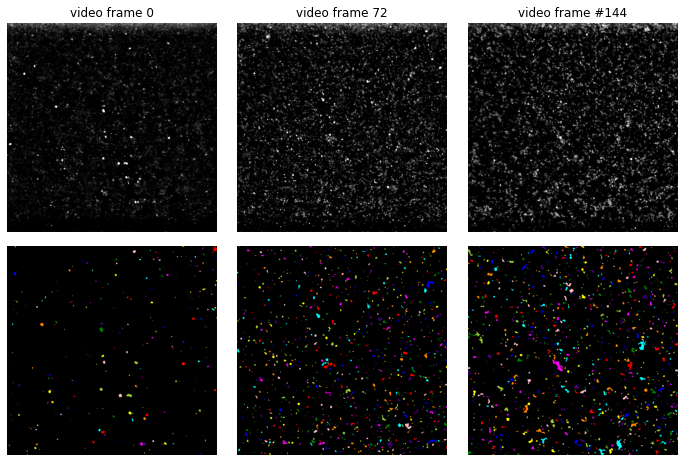

In [32]:
from skimage.color import label2rgb
L=50
size=800
label_video = process_video('images/cheese_gel.avi', threshold=0.3, skip_size=24, size=size)[[0,3,-1]]
real_video =get_video('images/cheese_gel.avi',skip_size=24)[[0,3,-1]]

# Create a figure and an array of subplots with 2 rows and 5 columns
fig, axs = plt.subplots(2, 3, figsize=(12, 8))  # Adjust the figsize as per your preference
titles= ['video frame 0', 'video frame 72','video frame #144']
# Iterate over the frames of the first series and plot them in the upper row
for i, frame in enumerate(real_video):
    axs[0, i].imshow(frame)  # Display the frame in the upper row subplot
    axs[0, i].axis('off')    # Turn off the axes for cleaner visualization
    axs[0, i].set_title(titles[i])
# Iterate over the frames of the second series and plot them in the lower row
for i, frame in enumerate(label_video):
    axs[1, i].imshow(label2rgb(label_video[i], bg_label=0))  # Display the frame in the lower row subplot
    axs[1, i].axis('off')    # Turn off the axes for cleaner visualization

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.05)

# Show the plot
plt.show()


In [39]:
size=800
label_video = process_video('images/cheese_gel.avi', threshold=0.3, skip_size=12, size=size)[:15]

In [40]:
F_list, G_list = analyse_video(label_video, L=L)

In [13]:
noise_array = generate_noise_array(size, amount=20, threshold=0.3, smooth=4)

In [14]:
noiseF_list, noiseG_list = analyse_video(noise_array, L=L)

/Users/Dorph/Documents/CS/3Y/Bachelor/QIM/src/distance_measures.py:38: RuntimeWarning: invalid value encountered in true_divide
  f = f / curr_image.max()
/Users/Dorph/Documents/CS/3Y/Bachelor/QIM/src/distance_measures.py:39: RuntimeWarning: invalid value encountered in true_divide
  g = g / curr_image.max()


In [15]:
# Taking mean of noisy images
noiseF = np.mean(noiseF_list, axis=0)
noiseG = np.mean(noiseG_list, axis=0)


In [42]:
import numpy as np
# import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.color import label2rgb
from IPython.display import display, clear_output


def visualize_(video, F_list, G_list, F_noise=np.array([]), G_noise=np.array([]), L=100, save=False):
    """Visualizes a list of data overlaps, can compare with one dataset"""
    fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
    # fig.subplots_adjust(wspace=0.4)
    plt.tight_layout()

    colors = cm.Blues(np.linspace(0.2, 1, len(video)))
    # plots = []

    for i in range(len(F_list)):
        M = video[i].shape[0] - L
        bx = (L, M, M, L, L)
        by = (L, L, M, M, L)

        ax[3].plot(bx, by, '-r')
        ax[3].imshow(label2rgb(video[i], bg_label=0))
        ax[3].set_title('video frame #144')

        ax[0].plot(F_list[i], color=colors[i])
        ax[0].set_xlabel('r')
        ax[0].set_ylabel('area overlap')
        ax[1].plot(F_list[i]/G_list[i], color=colors[i])
        ax[1].set_xlabel('r')
        ax[1].set_ylabel('fractional area overlap')
        ax[2].plot((F_list[i])[1:]-(F_list[i])[:-1], color=colors[i])
        ax[2].set_xlabel('r')
        ax[2].set_ylabel('curve overlap')

        # ax[0].set_ylim([0,2500])
        # ax[1].set_ylim([0,0.07])
        # ax[2].set_ylim([0,50])

        if save:
            filename = 'frames/subplot_{:03d}.png'.format(i)
            fig.savefig(filename)
            # plots.append(fig)

        display(fig)
        clear_output(wait = True)

    if F_noise.size and G_noise.size:
        ax[0].plot(F_noise, color='r')
        ax[1].plot(F_noise/G_noise, color='r')
        ax[2].plot(F_noise[1:]-F_noise[:-1], color='r')

    if save:
        filename = 'frames/subplot_{:03d}.png'.format(i+1)
        fig.savefig(filename)
        # plots.append(fig)

        # with imageio.get_writer('animation.gif', mode='I') as writer:
        #     for plot in plots:
        #         writer.append_data(imageio.core.image_as_uint(plot.canvas.renderer.buffer_rgba()))
    plt.show()


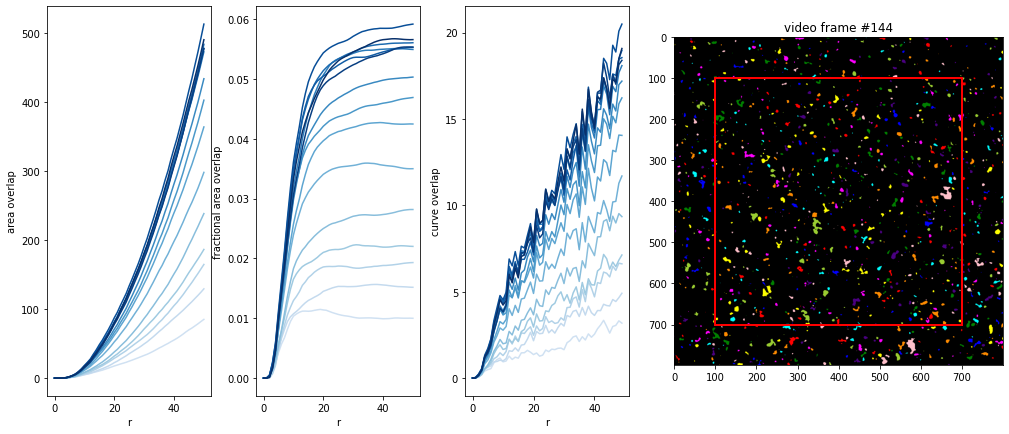

In [43]:
visualize_(label_video, F_list, G_list)

In [44]:
F_list

[array([0.00000000e+00, 0.00000000e+00, 2.12765957e-02, 8.51063830e-02,
        3.08510638e-01, 7.18085106e-01, 1.20744681e+00, 1.75531915e+00,
        2.63829787e+00, 3.70744681e+00, 4.86702128e+00, 5.80851064e+00,
        6.79787234e+00, 8.06914894e+00, 9.14893617e+00, 1.03617021e+01,
        1.15159574e+01, 1.29787234e+01, 1.44468085e+01, 1.60531915e+01,
        1.75531915e+01, 1.89148936e+01, 2.03670213e+01, 2.16382979e+01,
        2.29680851e+01, 2.45904255e+01, 2.61223404e+01, 2.77978723e+01,
        2.94468085e+01, 3.11702128e+01, 3.29095745e+01, 3.45531915e+01,
        3.66010638e+01, 3.87712766e+01, 4.11542553e+01, 4.35957447e+01,
        4.57127660e+01, 4.81063830e+01, 5.03138298e+01, 5.28723404e+01,
        5.52393617e+01, 5.77819149e+01, 6.06382979e+01, 6.37127660e+01,
        6.70585106e+01, 7.00478723e+01, 7.26542553e+01, 7.56436170e+01,
        7.86968085e+01, 8.20106383e+01, 8.51914894e+01]),
 array([0.00000000e+00, 0.00000000e+00, 6.94444444e-03, 8.33333333e-02,
      